In [1]:
from PIL import Image
image = Image.open('C:\\projects\\pokemon\DS06\\all\\007.png')

In [2]:
image.size

In [3]:
image

# Settings

In [4]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..'+sep_local+'..')
print(sep_local)

In [5]:
import tensorflow as tf
print(tf.__version__)

2.1.0


# Dataset loading

In [6]:
dataset_name='pokemon'

In [7]:
IMG_DIR = 'C:\\projects\\pokemon\DS06\\'
VAL_PCT = 10
VAL_FORMAT = 'png'

In [8]:
from training.generators.file_image_generator import create_image_lists, get_generators

Using TensorFlow backend.


In [9]:
imgs_list = create_image_lists(
    image_dir=IMG_DIR, 
    validation_pct=VAL_PCT, 
    valid_imgae_formats=VAL_FORMAT
)

  DEBUG    | Looking for images in 'all'


  INFO     | 809 file found


In [10]:
inputs_shape= IMG_SIZE=(200, 200, 3)
BATCH_SIZE = 32
latent_dim = 100
intermediate_dim = 100

In [11]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=IMG_DIR, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode=None
)

  INFO     | Found 738 training files


  INFO     | Found 71 validation files


In [12]:
batch = next(train_gen)

In [13]:
batch.shape

(32, 200, 200, 3)

In [14]:
from Augmentor.Operations import Operation, Skew, Distort, Rotate, Shear, Flip, Zoom, HistogramEqualisation

In [15]:
from utils.augmentation.Cloner import Clone
from utils.augmentation.Colorizer import Colorize

In [16]:
import random 

In [17]:
operations = {0: lambda: Skew(probability=1, skew_type="RANDOM", magnitude=1),
              1: lambda: Distort(probability=1, grid_width=random.randint(1, 50), grid_height=random.randint(1, 50), 
                                 magnitude=5),
              2: lambda: Rotate(probability=1, rotation=random.randint(1, 360)),
              3: lambda: Shear(probability=1, max_shear_left=0, max_shear_right=random.randint(5, 15)),
              4: lambda: Shear(probability=1, max_shear_left=random.randint(5, 15), max_shear_right=0),
              5: lambda: Flip(probability=1, top_bottom_left_right="RANDOM"),
              6: lambda: Zoom(probability=1, min_factor=random.randint(2, 10)/10, max_factor=random.randint(10, 12)/10), 
              7: lambda: HistogramEqualisation(probability=1),
              8: lambda: Colorize(probability=1),
              9: lambda: Clone(probability=1)
             }


In [18]:
def do_operation(opt, image):   
    return np.array(opt.perform_operation([Image.fromarray(image)])[0])/255.0

In [19]:
image = batch[0]

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [21]:
image_cv = cv2.cvtColor(image, cv2.IMREAD_COLOR)[...,::-1]
color = [0, 0, 0]
padding=50
top, bottom = padding, padding
left, right = padding, padding
image_cv = cv2.copyMakeBorder(image_cv, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)

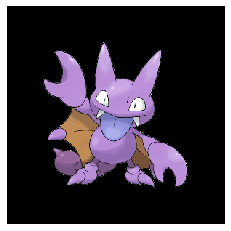

In [22]:
plt.imshow(image_cv)
plt.axis('off');

In [23]:
operations[0]

<function __main__.<lambda>()>

In [24]:
import numpy as np

operation Colorize ===================


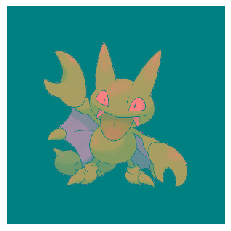

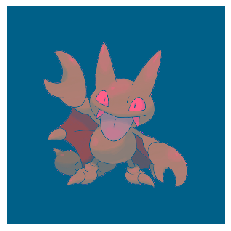

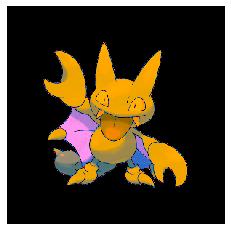

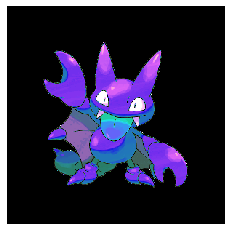

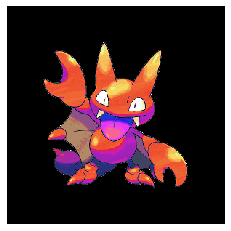

In [25]:
for i in [8]:#range(len(operations)):
    opt = operations[i]()
    print(f"operation {opt} ===================")
    for _ in range(5):
        opt = operations[i]()
        aug_image = do_operation(opt, (image_cv * 255).astype(np.uint8))
        plt.imshow(aug_image)
        plt.axis('off');
        plt.show()

In [26]:
train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen, 
    output_types=tf.float32 ,
    output_shapes=tf.TensorShape((BATCH_SIZE, ) + IMG_SIZE)
)


In [27]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data[0].numpy().max())
    break

In [28]:
_instance_scale

1.0

In [29]:
import numpy as np
from collections.abc import Iterable

In [30]:
if isinstance(inputs_shape, Iterable):
    _outputs_shape = np.prod(inputs_shape)

In [31]:
_outputs_shape

120000

# Model's Layers definition

In [32]:
enc_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=latent_dim)]

dec_lays = [tf.keras.layers.Dense(units=latent_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=_outputs_shape),
            tf.keras.layers.Reshape(inputs_shape)]

# Model definition

In [33]:
model_name = dataset_name+'AE'
recoding_dir='..'+sep_local+'..'+sep_local+'recoding'+sep_local+model_name

In [34]:
from training.traditional.autoencoders.autoencoder import autoencoder as AE

In [35]:
inputs_shape=IMG_SIZE

In [36]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_lays#enc_lays2#
    }

    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays#dec_lays2#
    }
]

In [37]:
from utils.data_and_files.file_utils import create_if_not_exist

In [38]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [39]:
create_if_not_exist(_restore)
_restore

'..\\..\\recoding\\pokemonAE\\var_save_dir'

In [40]:
#to restore trained model, set filepath=_restore

In [41]:
ae = AE( 
    name=model_name,
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=latent_dim,
    batch_size=BATCH_SIZE,
    variables_params=variables_params, 
    filepath=None
    )

ResourceExhaustedError: OOM when allocating tensor with shape[4000000,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense_2/kernel/Initializer/random_uniform/mul/

In [ ]:
#ae.compile(metrics=None)
ae.compile()

# Callbacks

In [ ]:
from training.callbacks.progress_bar import NotebookPrograssBar
from training.callbacks.sample_generation import SampleGeneration
from training.callbacks.save_model import ModelSaver

In [ ]:
progbar = NotebookPrograssBar(leave_outer=False)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=1e-12, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

In [ ]:
ms = ModelSaver(filepath=_restore,save_freq=5)

In [ ]:
csv_dir = os.path.join(recoding_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, ae.name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
csv_dir

In [ ]:
image_gen_dir = os.path.join(recoding_dir, 'image_gen_dir')
create_if_not_exist(image_gen_dir)

In [ ]:
sg = SampleGeneration(latent_shape=latent_dim, filepath=image_gen_dir, gen_freq=5, save_img=True, gray_plot=False)

In [ ]:
import numpy as np

# Model Training

In [ ]:
ae.fit(
    x=train_ds,
    input_kw=None,
    steps_per_epoch=50,
    epochs=int(1e6), 
    verbose=0,
    callbacks=[progbar, es, ms, csv_log, sg],
    workers=-1,
    use_multiprocessing=True
)